# Classification of earnings
Now we'll look at an actual example of real-world data, where our aim is to use details about a person to predict whether or not they earn more than $50,000 per year.

Run the cell below to download the data

In [1]:
!mkdir ./data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data -O ./data/adult.csv

mkdir: ./data: File exists
--2020-02-24 16:16:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘./data/adult.csv’

./data/adult.csv    100%[===================>]   3.79M   725KB/s    in 7.3s    

2020-02-24 16:16:28 (535 KB/s) - ‘./data/adult.csv’ saved [3974305/3974305]



In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Union, Optional, Tuple
from collections import OrderedDict, defaultdict, deque
import os
import math
from pathlib import Path

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.forest import ForestRegressor
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from typing import *
from fastprogress import progress_bar

import torch
from torch import nn, Tensor, optim
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader, Dataset
from torch.nn import BCELoss

# Data Importing
The data is in *Comma Separated Value* (CSV) format. To load it up, we'll use Pandas.

In [2]:
df = pd.read_csv('data/adult.csv', header=None); print(len(df)); df.head()

32561


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Column names
In the dataset as is, the features (columns) are just numbers. We can set them to a more human-readable format

In [3]:
df.columns = [ "Age", "WorkClass", "fnlwgt", "Education", "EducationNum", "MaritalStatus", "Occupation",
              "Relationship", "Race", "Gender", "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Target"]

In [4]:
df.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


We need a numerical target for our model, so we'll map <=50K to 0, and >50K to 1

In [5]:
set(df.Target)

{' <=50K', ' >50K'}

In [6]:
df['Target'] = df.Target.map({' <=50K': 0, ' >50K': 1})

There seems to be a class imbalance, but we'll ignore it for now

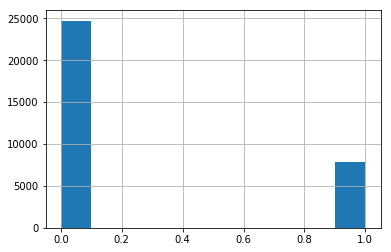

In [7]:
df.Target.hist()

## Validation set
Since we're fitting our model to data, we want to have an unbiased estimate of its performance to help optimise the architecture before we apply the model to the testing data. We can randomly sample a *validation* set from the training data.

In [8]:
_, val_ids = train_test_split(df.index, stratify=df.Target, test_size=0.2, random_state=0)

To help reduce code overhead in the next step, we'll simply set flag in the data for whether or not we want to use each row for training or validation.

In [9]:
df['val'] = 0
df.loc[val_ids, 'val'] = 1

# Feature processing
The data contains both continuous features (real values with numerical comparison) and categorical features (discreet values or string labels with no numerical comparison). Each need to be treated slightly differently.

In [10]:
cat_feats = ['WorkClass', 'Education', 'MaritalStatus', 'Occupation',
             'Relationship', 'Race', 'Gender', 'NativeCountry']
cont_feats = ['Age', 'fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']
train_feats = cont_feats+cat_feats

## Categorical encoding
Our model can only function on numbers, but the categorical features use strings. We can map these string values to integers in order to feed the data into our model. We also want to know whether there are categories which only appear in either training or testing

So, the training data contains an extra country which doesn't appear in the testing data, however the model may well be able to learn things from the extra data which are invarient to country, so we'll keep it in.

We need to ensure the same string --> integer mapping is applied to both training and testing, in order to make sure the data still has the same meaning when we apply the model to the testing data. We'll also construct dictionaries to keep track of the mapping. **N.B.** Pandas has a dedicated column type `Categorical` for helping with this kind of data, but we'll stick with integer mapping for now.

In [11]:
cat_maps = defaultdict(dict)
for feat in ['WorkClass', 'Education', 'MaritalStatus', 'Occupation',
             'Relationship', 'Race', 'Gender', 'NativeCountry']:
    for i, val in enumerate(set(df[feat])):
        cat_maps[feat][val] = i
        df.loc[df[feat] == val, feat] = i

In [12]:
df.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Target,val
0,39,6,77516,11,13,4,14,0,3,0,2174,0,40,29,0,0
1,50,2,83311,11,13,3,10,3,3,0,0,0,13,29,0,0
2,38,3,215646,12,9,1,8,0,3,0,0,0,40,29,0,0
3,53,3,234721,7,7,3,8,3,0,0,0,0,40,29,0,0
4,28,3,338409,11,13,3,4,4,0,1,0,0,40,19,0,0


Looks good, our data now only contains numerical information

## Continuous preprocessing
The weight initialisation we use is optimal for inputs which are unit-Gaussian. The closest we can get is to shift and scale each feature to have mean zero and standard deviation one. `SK-Learn` has `Pipeline` classes to handle series of transformations to data, and we'll use the `StandardScaler` to transform the data.

In [13]:
input_pipe = Pipeline([('norm_in', StandardScaler(with_mean=True, with_std=True))])

Next we need to fit the transformation to the data. Note the Boolean indexing of the data.

In [14]:
input_pipe.fit(df[df.val == 0][cont_feats].values.astype('float32'))

Pipeline(memory=None,
         steps=[('norm_in',
                 StandardScaler(copy=True, with_mean=True, with_std=True))],
         verbose=False)

And finally apply the transformation to the training, validation, and testing data.

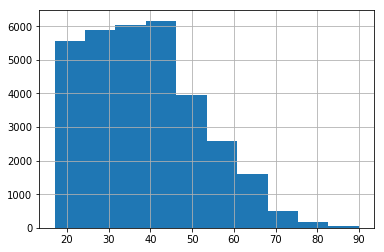

In [15]:
df.Age.hist()

In [16]:
df[cont_feats] = input_pipe.transform(df[cont_feats].values.astype('float32'))

We can check the transformation by plotting an example feature

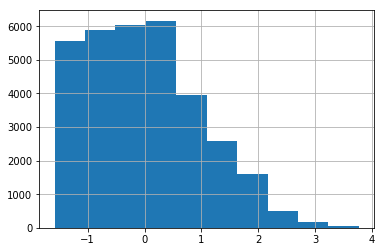

In [17]:
df.Age.hist()

# Model 
Now we need to build a model to fit to the data. Use the previous two example notebooks to help write a function which returns an appropriate model.

In [17]:
class NPDataset(Dataset):
    r'''
    Dataset for dealing with Numpy arrays
    
    Arguments:
        x: input data
        y: Optional target data
        shuffle: whether to shuffle input and target data prior to iteration
        bulk_move: whether to move entire dataset to device at start of iteration (quicker) or move batch by batch (memory efficient)
        bs: batchsize, number of datapoints per minibatch
        device: set to either cuda or cpu, or leave as None for cuda if available else cpu
        drop_last: whether to drop last batch if it is smaller than bs
    '''
    
    def __init__(self, x:np.ndarray, y:Optional[np.ndarray]=None, shuffle:bool=True, bulk_move:bool=True, bs:int=64,
                 device:Optional[torch.device]=None, drop_last:bool=True):
        self.shuffle,self.bulk_move,self.bs,self.drop_last = shuffle,bulk_move,bs,drop_last
        if device is None: self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        else:              self.device = device
        self.x = x.astype('float32')
        if len(self.x.shape) == 1: self.x = self.x[:,None]
        if y is None:
            self.y = y
        else:
            self.y = y.astype('float32')
            if len(self.y.shape) == 1: self.y = self.y[:,None]

    def __len__(self) -> int:
        r'''
        Returns the number of datapoints in the dataset
        '''
        
        return len(self.x)

    def __getitem__(self, idx:int) -> Tuple[Any,Any]:
        r'''
        Returns a single datapoint at the requested index
        '''
        
        if self.y is None: return self.x[idx]
        else:              return self.x[idx], self.y[idx]
        
    def __iter__(self) -> Tuple[Tensor,Tensor]:
        r'''
        Iterates through the entire (shuffled) dataset, yielding minibatches of Tensors on device
        '''
        
        if self.shuffle:
            data = list(zip(self.x, self.y))
            np.random.shuffle(data)
            inputs, targets = zip(*data)
        else:
            inputs, targets = self.x, self.y
            
        if self.bulk_move:  # Moves entire dataset to device
            inputs  = Tensor(inputs).to(self.device)
            if targets is not None: targets = Tensor(targets).to(self.device)
            if self.drop_last:
                for i in range(0, len(inputs)-self.bs+1, self.bs):
                    if targets is not None: yield inputs[i:i+self.bs], targets[i:i+self.bs]
                    else:                   yield inputs[i:i+self.bs]
            else:
                for i in range(0, len(inputs)+1, self.bs):
                    if targets is not None:
                        if i+self.bs < len(inputs): yield inputs[i:i+self.bs], targets[i:i+self.bs]
                        else:                       yield inputs[i:],          targets[i:]
                    else:
                        if i+self.bs < len(inputs): yield inputs[i:i+self.bs]
                        else:                       yield inputs[i:]
        else:
            if self.drop_last:
                for i in range(0, len(inputs)-self.bs+1, self.bs):
                    if targets is not None:
                        yield Tensor(inputs[i:i+self.bs]).to(self.device), Tensor(targets[i:i+self.bs]).to(self.device)
                    else:
                        yield Tensor(inputs[i:i+self.bs]).to(self.device)
            else:
                for i in range(0, len(inputs)+1, self.bs):
                    if targets is not None:
                        if i+self.bs < len(inputs):
                            yield Tensor(inputs[i:i+self.bs]).to(self.device), Tensor(targets[i:i+self.bs]).to(self.device)
                        else:
                            yield Tensor(inputs[i:]).to(self.device),          Tensor(targets[i:]).to(self.device)
                    else:
                        if i+self.bs < len(inputs): yield Tensor(inputs[i:i+self.bs]).to(self.device)
                        else:                       yield Tensor(inputs[i:]).to(self.device)                

In [18]:
class NN(nn.Module):
    r'''
    Full-connected neural network with user-defined depth and width (same width for all dense layers).
    User-configurable output activation function (None for regression, nn.Sigmoid for classification).
    Internal activations are nn.ReLU
    
    Arguments:
        n_int: number of inputs
        depth: number of hidden layers
        width: size of hidden layers
        n_out: width of output layer
        out_act: activation function for output layer (if any)
    '''
    
    def __init__(self, n_in:int, depth:int, width:int, n_out:int, out_act:Optional[Callable[[],nn.Module]]):
        super().__init__()  # nn.Module.__init__ must always be called to correctly initialise class
        if out_act is None: out_act = lambda: None
        self.layers = nn.Sequential(*[self._get_layer(n_in      = n_in      if d   == 0       else width,
                                                      n_out     = width     if d <  depth else n_out,
                                                      act       = nn.ReLU() if d <  depth else out_act(),
                                                      out_layer = d == depth)
                                      for d in range(depth+1)])
        
    @staticmethod
    def _get_layer(n_in:int, n_out:int, act:Optional[nn.Module], out_layer:bool) -> nn.Sequential:
        r'''
        Returns a correctly initialised dense layer and optionally an activation layer, as a Sequential model
        '''
        
        layers = []
        
        # Create a single layer and initialise weights and biases
        layers.append(nn.Linear(n_in, n_out))
        if out_layer: nn.init.xavier_normal_(layers[-1].weight)
        else:         nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='relu')
        nn.init.zeros_(layers[-1].bias)
        
        # Add activation funtion
        if act is not None: layers.append(act)
        return nn.Sequential(*layers)
    
    def forward(self, x:Tensor) -> Tensor:
        r'''
        Passing input tensor through the neural network and returns the output
        '''
        
        return self.layers(x)

In [63]:
class Model():
    r'''
    Class wrapping a neural network (nn.Module) providing fitting and prediction methods
    
    Arguments:
        model: the network to wrap
        device: set to either cuda or cpu, or leave as None for cuda if available else cpu
        bulk_move: whether to move entire dataset to device at start of iteration (quicker) or move batch by batch (memory efficient)
    '''
    
    def __init__(self, model:nn.Module, device:Optional[torch.device]=None, bulk_move:bool=True):
        if device is None: self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        else:              self.device = device
        self.model = self.to_device(model, self.device)
        self.opt = optim.Adam(self.model.parameters())
        self._n_out = self.get_n_out()
        self.bulk_move = bulk_move
        
    def __repr__(self) -> str:
        return f'''Model:\n{self.model}
        \n\nNumber of trainable parameters: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}
        \n\nOptimiser:\n{self.opt}
        '''
    
    def get_n_out(self) -> None:
        r'''
        Gets the number of outputs of the network
        '''
        
        l = deque(self.model.parameters(), maxlen=1).pop()
        return len(l.shape)
    
    @staticmethod
    def to_device(x:Union[Tensor,List[Tensor]], device:torch.device) -> Union[Tensor,List[Tensor]]:
        r'''
        Recursively places Tensor(s) onto device

        Arguments:
            x: Tensor(s) to place on device

        Returns:
            Tensor(s) on device
        '''

        if x is None: return x
        if isinstance(x, list): return [Model.to_device(o, device) for o in x]
        return x.to(device)
    
    @staticmethod
    def to_np(x:Tensor) -> np.ndarray:
        r'''
        Converts Tensor x to a Numpy array

        Arguments:
            x: Tensor to convert

        Returns:
            x as a Numpy array
        '''

        return x.cpu().detach().numpy()
    
    def set_lr(self, lr:float) -> None:
        r'''
        Sets learning rate of optimiser
        '''

        self.opt.param_groups[0]['lr'] = lr
    
    def fit(self, x:np.ndarray, y:np.ndarray,
            lr:float, batchsize:int, loss_fn:_Loss, n_epochs:int,
            x_val:Optional[np.ndarray]=None, y_val:Optional[np.ndarray]=None) -> Tuple[List[float],List[float]]:
        r'''
        Fits model to data (optionally using validation data) for a set number of epochs.
        
        Arguments:
            x: training inputs
            y: training targets
            lr: learning rate
            batchsize: size of minibatches
            loss_fn: Loss function to use
            n_epochs: number of epochs to train
            x_val: optional validation inputs
            y_val: optional validation targets
        
        Returns:
            Tuple of train and validation losses
        '''
        
        trn_losses,val_losses = [],[]
        trn_dl = NPDataset(x,y, bs=batchsize, shuffle=True, bulk_move=self.bulk_move, device=self.device)
        self.set_lr(lr)
        
        epoch_pb = progress_bar(range(n_epochs), display=True, leave=True)
        for e in epoch_pb:
            losses = []  # Holder for losses during epoch
            self.model.train()  # Put model into train mode (local gradients saved during forward pass, dropout active, etc.)
            for x, y in trn_dl:  # Loop over batches
                x,y = self.to_device(x, self.device),self.to_device(y, self.device)  # Put data on device
                y_pred = self.model(x)  # Run forward pass of network and get prediction
                loss = loss_fn(y_pred, y)  # Compute loss of prediction
                losses.append(loss.data.item())  # Get value of loss
                self.opt.zero_grad()  # Reset recorded gradients
                loss.backward()  # Propagate loss gradient backwards through network
                self.opt.step()  # Perform one update step to network parameters
            
            trn_losses.append(np.mean(losses))
            if x_val is not None:
                val_losses.append(self.evaluate(x_val,y_val, batchsize=batchsize, loss_fn=loss_fn))
                epoch_pb.comment = f'Epoch {e+1}, best loss: {np.min(val_losses):.4E}'
            else:
                epoch_pb.comment = f'Epoch {e+1}, best loss: {np.min(trn_losses):.4E}'
        self.plot_train_history([trn_losses,val_losses])
        return trn_losses,val_losses
    
    def evaluate(self, x:np.ndarray, y:np.ndarray, batchsize:int, loss_fn:_Loss) -> float:
        r'''
        Computes mean loss on network predicitons for data
        '''
        
        self.model.eval()  # Put model into eval mode no grads saved, dropout turned off, etc.
        loss = []
        dl = NPDataset(x,y, bs=batchsize, shuffle=True, bulk_move=self.bulk_move, device=self.device)
        for x, y in dl:  # Loop over batches
            x,y = self.to_device(x, self.device),self.to_device(y, self.device)  # Put data on device
            y_pred = self.model(x)  # Run forward pass of network and get prediction
            loss.append(loss_fn(y_pred, y).data.item())  # Get value of loss
        return np.mean(loss)
    
    def predict(self, x:np.ndarray, batchsize:Optional[int]=None) -> np.ndarray:
        r'''
        Computes preditions for network on data
        '''
        
        self.model.eval()  # Put model into eval mode no grads saved, dropout turned off, etc.
        if batchsize is None:  # Compute all predictions at once
            x = x.astype('float32')
            if len(x.shape) == 1: x = x[:,None]
            preds = self.model(self.to_device(Tensor(x), self.device))
        else:
            dl = NPDataset(x, bs=batchsize, shuffle=False, bulk_move=self.bulk_move, drop_last=False, device=self.device)
            preds = torch.zeros((len(x),self._n_out), device=self.device)
            for i, x in enumerate(progress_bar(dl, leave=True)):  # Loop over batches
                x = self.to_device(x, self.device)  # Put inputs on device
                ps = self.model(x)  # Run forward pass of network and get prediction
                if len(ps) == batchsize: preds[i*batchsize:(1+i)*batchsize] = ps
                else:                    preds[i*batchsize:]                = ps  # Last batch
        return self.to_np(preds)
    
    @staticmethod
    def plot_train_history(history:Tuple[List[float],List[float]]) -> None:
        r'''
        Plots loss evolution as a function of training epoch
        '''
        plt.figure(figsize=(16,9))
        plt.plot(history[0], label='Training')
        plt.plot(history[1], label='Validation')
        plt.legend(loc='upper right', fontsize=16)
        if history[0][0]/np.min(history[0]) > 50: plt.yscale('log', nonposy='clip')
        plt.grid(True, which="both")
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlabel("Epoch", fontsize=24)
        plt.ylabel("Loss", fontsize=24)
        plt.show()

In [64]:
model = Model(NN(n_in=len(train_feats), depth=2, width=100, n_out=1, out_act=nn.Sigmoid)); model

Model:
NN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=108, out_features=100, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)
        

Number of trainable parameters: 21101
        

Optimiser:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
        

Now we need to extract out our inputs and targets

In [29]:
x, y = df[df.val == 0][train_feats].values, df[df.val == 0]['Target'].values
x_val, y_val = df[df.val == 1][train_feats].values, df[df.val == 1]['Target'].values
len(x)

26048

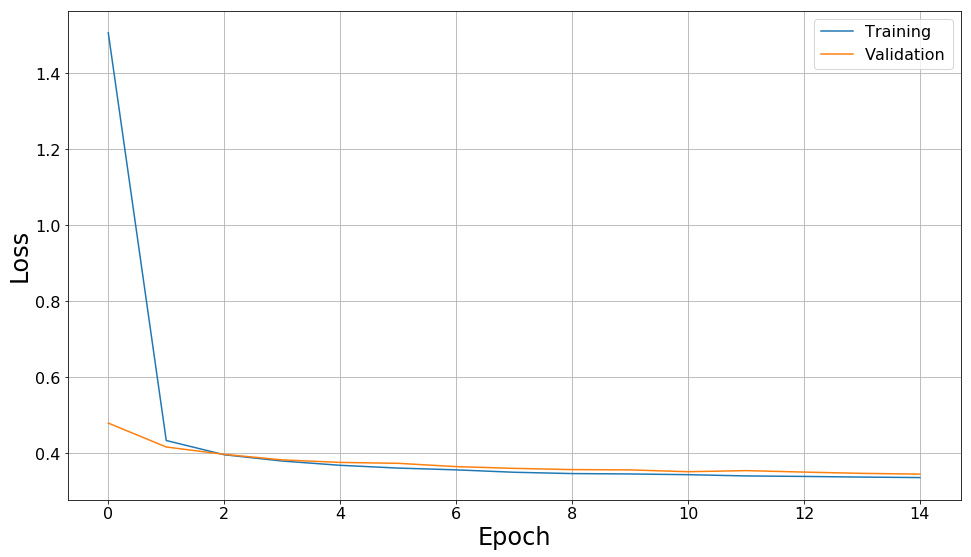

In [30]:
hist = model.fit(x=x, y=y, x_val=x_val, y_val=y_val, batchsize=128, n_epochs=15, lr=1e-4, loss_fn=BCELoss())

In [31]:
def score_model(model:nn.Module, x_val:np.ndarray, y_val:np.ndarray) -> Tuple[float,float]:
    preds = model.predict(x_val)
    acc = accuracy_score(y_val, preds.round())
    roc_auc = roc_auc_score(y_val, preds)
    plt.figure(figsize=(5,5))
    plt.plot(*roc_curve(y_val, preds)[:2], label=f'ROC AUC={roc_auc:.3f}, ACC={acc:.3f}')
    plt.legend()
    plt.show()
    return (acc, roc_auc)

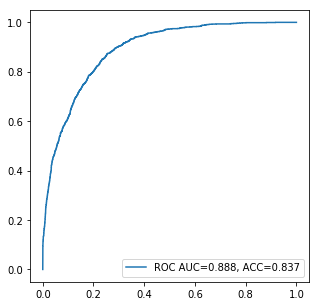

In [32]:
_ = score_model(model, x_val, y_val)

# 1-hot encoding
Are treatment of categorical features so far has simply allowed use to feed the inputs into the model, however NNs have a continuous response to inputs and by encoding as integers we have implied a numerical comparison between categories.
An encoding which removes this implication and allows the network to construct separate responses to each category is to expand each feature in to a series of features, one for each category, and mark the correct column with a 1, and the rest as zeros, e.g Monday --> (1,0,0,0,0,0,0)

Pandas has a function to do this.

In [33]:
df = pd.get_dummies(df, columns=cat_feats)

In [34]:
df.head()

,Age,fnlwgt,EducationNum,CapitalGain,CapitalLoss,HoursPerWeek,Target,val,WorkClass_0,WorkClass_1,...,NativeCountry_32,NativeCountry_33,NativeCountry_34,NativeCountry_35,NativeCountry_36,NativeCountry_37,NativeCountry_38,NativeCountry_39,NativeCountry_40,NativeCountry_41
0,0.030732,-1.062885,1.130588,0.143026,-0.212386,-0.032432,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.837016,-1.007998,1.130588,-0.146647,-0.212386,-2.222496,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,-0.042567,0.245392,-0.414712,-0.146647,-0.212386,-0.032432,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1.056912,0.426057,-1.187362,-0.146647,-0.212386,-0.032432,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,-0.775553,1.408122,1.130588,-0.146647,-0.212386,-0.032432,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As we can see, the original categorical columns have been removed and replaced by dedicated columns for each feature category.

Note that the number of input features has now shot up from 13 to 108: 1-hot encoding is not an efficient method, but should help our model to better access the information in the data.

In [35]:
cat_feats = [f for f in df.columns if f not in cont_feats+['Target', 'val']]
train_feats = cont_feats+cat_feats
len(train_feats)

108

In [36]:
model = Model(NN(n_in=len(train_feats), depth=2, width=100, n_out=1, out_act=nn.Sigmoid)); model

Model:
NN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=108, out_features=100, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)
        

Number of trainable parameters: 21101
        

In [37]:
x, y = df[df.val == 0][train_feats].values, df[df.val == 0]['Target'].values
x_val, y_val = df[df.val == 1][train_feats].values, df[df.val == 1]['Target'].values
len(x)

26048

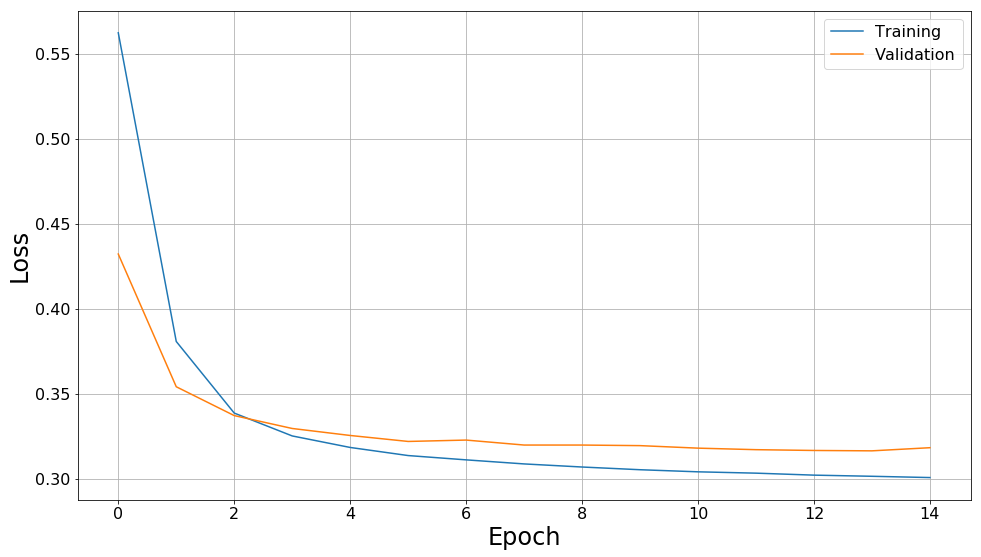

In [38]:
hist = model.fit(x=x, y=y, x_val=x_val, y_val=y_val, batchsize=128, n_epochs=15, lr=1e-4, loss_fn=BCELoss())

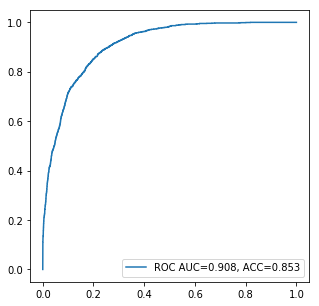

In [39]:
_ = score_model(model, x_val, y_val)

Slight improvements to our metrics

# Regularisation
Occasionally, we can have a situation in which the validation performance begins to decrease, where as the training performance continues to improve:

In [40]:
model = Model(NN(n_in=len(train_feats), depth=12, width=100, n_out=1, out_act=nn.Sigmoid)); model

Model:
NN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=108, out_features=100, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (5): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (6): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (7): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (8): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1

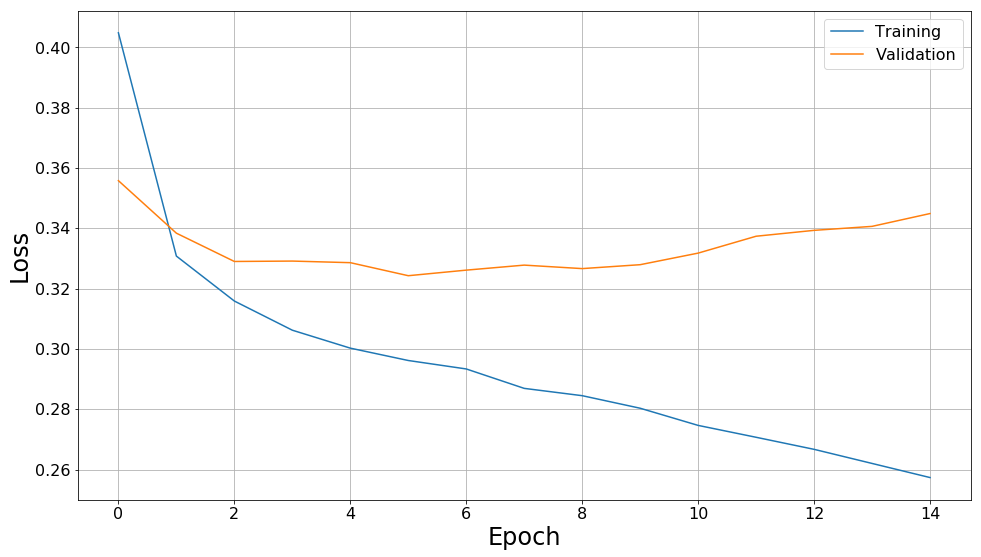

In [41]:
hist = model.fit(x=x, y=y, x_val=x_val, y_val=y_val, batchsize=128, n_epochs=15, lr=1e-4, loss_fn=BCELoss())

Here we can see that the validation loss minimises very quickly, and then begins to increase, spoiling performance. This is an example of *over-training*. There are many causes of over training, and here we made a very large network which begins to memorise the training data instead of learning general patters which extrapolate well to the validation data.

Ideally, we want to stop the training when the performance on validation is best. One way to effectively do this is to save copies of the network whenever the validation loss reaches a new lowest value. After training is finished we can then load the model to get back to the point of best validation performance.

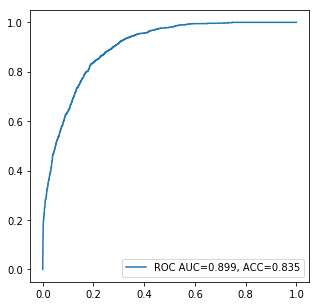

(0.8347919545524336, 0.8994922463424198)

In [42]:
score_model(model, x_val, y_val)

In [51]:
class SaveBestModel(Model):
    r'''
    Class wrapping a neural network (nn.Module) providing fitting and prediction methods
    Automatically saves the best model during training.
    '''

    def fit(self, x:np.ndarray, y:np.ndarray,
            lr:float, batchsize:int, loss_fn:_Loss, n_epochs:int,
            x_val:Optional[np.ndarray]=None, y_val:Optional[np.ndarray]=None) -> Tuple[List[float],List[float]]:
        r'''
        Fits model to data (optionally using validation data) for a set number of epochs.
        Automatically tracks best performance and loads best model at end of training
        
        Arguments:
            x: training inputs
            y: training targets
            lr: learning rate
            batchsize: size of minibatches
            loss_fn: Loss function to use
            n_epochs: number of epochs to train
            x_val: optional validation inputs
            y_val: optional validation targets
        
        Returns:
            Tuple of train and validation losses
        '''
        
        def save_best(loss:float, best_loss:float) -> float:
            if loss < best_loss:
                best_loss = loss
                print(f'New best loss of {best_loss:.3E}')
                self.save("best.h5")
            return best_loss
        
        self.model.train()  # Put model into train mode (local gradients saved during forward pass, dropout active, etc.)
        trn_losses,val_losses = [],[]
        trn_dl = NPDataset(x,y, bs=batchsize, shuffle=True, bulk_move=self.bulk_move)
        self.opt.param_groups[0]['lr'] = lr  # Set learning rate of optimiser
        best_loss = math.inf
        
        epoch_pb = progress_bar(range(n_epochs), display=True, leave=True)
        for e in epoch_pb:
            losses = []  # Holder for losses during epoch
            for x, y in trn_dl:  # Loop over batches
                x,y = self.to_device(x, self.device),self.to_device(y, self.device)  # Put data on device
                y_pred = self.model(x)  # Run forward pass of network and get prediction
                loss = loss_fn(y_pred, y)  # Compute loss of prediction
                losses.append(loss.data.item())  # Get value of loss
                self.opt.zero_grad()  # Reset recorded gradients
                loss.backward()  # Propagate loss gradient backwards through network
                self.opt.step()  # Perform one update step to network parameters
            
            trn_losses.append(np.mean(losses))
            if x_val is not None:
                val_losses.append(self.evaluate(x_val,y_val, batchsize=batchsize, loss_fn=loss_fn))
                epoch_pb.comment = f'Epoch {e+1}, best loss: {np.min(val_losses):.4E}'
                best_loss = save_best(val_losses[-1], best_loss)
            else:
                epoch_pb.comment = f'Epoch {e+1}, best loss: {np.min(trn_losses):.4E}'
                best_loss = save_best(trn_losses[-1], best_loss)
        
        print(f'Fit complete loading best model with loss of {best_loss:.3E}')
        self.load("best.h5")
        self.plot_train_history([trn_losses,val_losses])
        return trn_losses,val_losses
    
    def save(self, filename:Union[Path,str]) -> None:
        torch.save({'model':self.model.state_dict(), 'opt':self.opt.state_dict()}, str(filename))
        
    def load(self, filename:Union[Path,str]) -> None:
        state = torch.load(str(filename), map_location=self.device.type)
        self.model.load_state_dict(state['model'])
        self.opt.load_state_dict(state['opt'])
    
    @staticmethod
    def plot_train_history(history:Tuple[List[float],List[float]]) -> None:
        r'''
        Plots loss evolution as a function of training epoch
        '''
        plt.figure(figsize=(16,9))
        plt.plot(history[0], label='Training')
        if len(history[1]) > 0:
            plt.plot(history[1], label='Validation')
            plt.vlines(np.argmin(history[1]), ymin=np.min(history[0]), ymax=np.max(history[0]), linestyles='--')
        else:
            plt.vlines(np.argmin(history[0]), ymin=np.min(history[0]), ymax=np.max(history[0]), linestyles='--')
        plt.legend(loc='upper right', fontsize=16)
        if history[0][0]/np.min(history[0]) > 50: plt.yscale('log', nonposy='clip')
        plt.grid(True, which="both")
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlabel("Epoch", fontsize=24)
        plt.ylabel("Loss", fontsize=24)
        plt.show()

In [52]:
model = SaveBestModel(NN(n_in=len(train_feats), depth=12, width=100, n_out=1, out_act=nn.Sigmoid)); model

Model:
NN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=108, out_features=100, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (5): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (6): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (7): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (8): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1

New best loss of 3.556E-01
New best loss of 3.372E-01
New best loss of 3.328E-01
New best loss of 3.296E-01
New best loss of 3.267E-01
Fit complete loading best model with loss of 3.267E-01


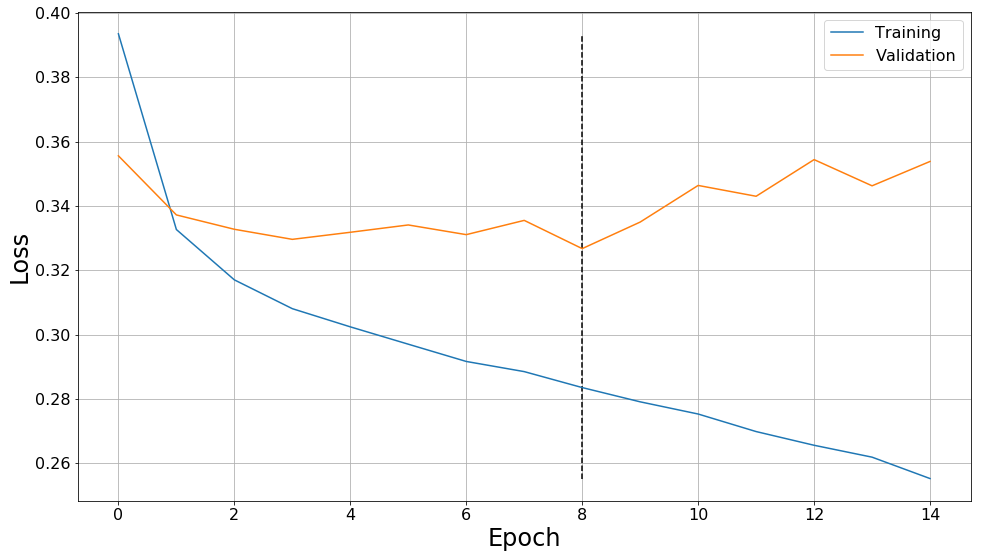

In [53]:
hist = model.fit(x=x, y=y, x_val=x_val, y_val=y_val, batchsize=128, n_epochs=15, lr=1e-4, loss_fn=BCELoss())

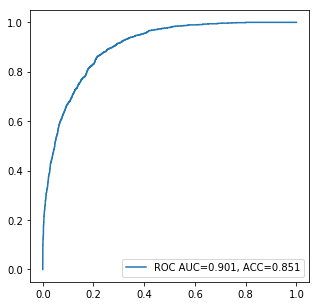

In [54]:
_ = score_model(model, x_val, y_val)

So we removed the over-training by *early-stopping*. Ideally, this implementation would track the number of epochs passed since the last improvement in validation loss and actually stop training early, to save time (you can add this in if you want).

Whilst it removed the over-training, the score is still not as good as the previous model. Note however that the training loss does reach lower values than before. This is *over-fitting*  and is a bit of a more difficult problem to solve, since there are many causes and many potential solutions. Note that over-fitting does **not** refer directly to the difference between training and validation performance, but rather to the fact that the model fits to *noise* in the training data.

At the point of the black dotted line, the network is fitted as best as possible given the hyper-parameter settings, however since the network then goes on to reach better performance on the training set than it previously could with the smaller models, we know that the model has the potential to perform better, but is not encouraged to do so and it is this which indicates over-fitting. Are aim is to train a model such that we get the best possible score on the validation data. We know, that reducing the size of the model helps improve the score, but what if some other solution could be used to full utilise the larger model to reach an even better score?

Techniques and factors which combat over-fitting are called *regularisation*, and there are many different forms; e.g. some explicitly controlled (e.g. dropout and weight decay), whilst others occur implicitly due to decisions (such as choosing not to simplify data formats). See https://arxiv.org/abs/1710.10686 for a good discussion on regularisation.

https://arxiv.org/abs/1803.09820 argues that explicit regularisation techniques should be tuned towards the end of architecture optimisation, since the can easily be adjusted to the given architecture, dataset, and other forms of regularisation already present in the system. Two common forms are: $L_2$ regularisation (e.g. [Ng, 04](https://icml.cc/Conferences/2004/proceedings/papers/354.pdf); which penalises the loss based on the sum of magnitures of network parameters - parameters only diverge from zero if they bring loss improvements greater than the penalty term; and dropout ([Srivastava et al, 14](http://jmlr.org/papers/v15/srivastava14a.html), which randomly removes neurons during training - the network is forced to learn redundant paths and so generalise to training data.

Let's write new networks and models that allow us to include dropout rates and $L_2$. Beware: $L_2$ is sometimes called *weight decay* (penalisation of the weight updates). These are actually two different penalties that just happen to be equivalent of vanilla stochastic-gradient-descent. Because of this the two terms are often used interchangeable but most libraries only implement $L_2$ regularisation. For the Adam optimiser, however, $L_2$ and weight decay are not equivalent, and experimentally it has been shown experimentally (e.g. https://arxiv.org/abs/1711.05101) that Adam works best with weight decay (see https://www.fast.ai/2018/07/02/adam-weight-decay/ for more). We'll therefore switch to using the [`AdamW`](https://pytorch.org/docs/stable/optim.html#torch.optim.AdamW) which correctly implements weight decay.

In [55]:
class DropoutNN(NN):
    r'''
    Full-connected neural network with user-defined depth and width (same width for all dense layers) and dropout.
    User-configurable output activation function (None for regression, nn.Sigmoid for classification).
    Internal activations are nn.ReLU
    
    Arguments:
        n_int: number of inputs
        depth: number of hidden layers
        width: size of hidden layers
        n_out: width of output layer
        out_act: activation function for output layer (if any)
        do: dropout rate
    '''
    
    def __init__(self, n_in:int, depth:int, width:int, n_out:int, out_act:Optional[Callable[[],nn.Module]],
                 do:Optional[float]=None):
        self.do = do
        super().__init__(n_in=n_in, depth=depth, width=width, n_out=n_out, out_act=out_act)
        
    def _get_layer(self, n_in:int, n_out:int, act:Optional[nn.Module], out_layer:bool) -> nn.Sequential:
        r'''
        Returns a correctly initialised dense layer and optionally an activation layer, as a Sequential model
        '''
        layers = super()._get_layer(n_in, n_out, act, out_layer)
        if not out_layer and self.do > 0: layers.add_module("DO", nn.Dropout(self.do))
        return layers

In [59]:
class RegularisationModel(SaveBestModel):
    r'''
    Model wrapper which uses AdamW and has configurable weight decay during training
    
    Arguments:
        model: the network to wrap
        device: set to either cuda or cpu, or leave as None for cuda if available else cpu
        bulk_move: whether to move entire dataset to device at start of iteration (quicker) or move batch by batch (memory efficient)
    '''
    
    def __init__(self, model:nn.Module, device:Optional[torch.device]=None, bulk_move:bool=True):
        super().__init__(model=model, device=device, bulk_move=bulk_move)
        self.opt = optim.AdamW(self.model.parameters())
        
    def set_wd(self, wd:float) -> None:
        r'''
        Sets weight decay parameter for optimiser
        '''

        self.opt.param_groups[0]['weight_decay'] = wd
    
    def fit(self, x:np.ndarray, y:np.ndarray,
            lr:float, batchsize:int, loss_fn:_Loss, n_epochs:int, wd:Optional[float]=None,
            x_val:Optional[np.ndarray]=None, y_val:Optional[np.ndarray]=None) -> Tuple[List[float],List[float]]:
        r'''
        Fits model to data (optionally using validation data) for a set number of epochs.
        Automatically tracks best performance and loads best model at end of training
        
        Arguments:
            x: training inputs
            y: training targets
            lr: learning rate
            batchsize: size of minibatches
            loss_fn: Loss function to use
            n_epochs: number of epochs to train
            wd: amount of weight decay penalisation
            x_val: optional validation inputs
            y_val: optional validation targets
        
        Returns:
            Tuple of train and validation losses
        '''
        
        if wd is None: wd = 0
        self.set_wd(wd)
        return super().fit(x=x, y=y, lr=lr, batchsize=batchsize, loss_fn=loss_fn, n_epochs=n_epochs,
                           x_val=x_val, y_val=y_val)

In [60]:
model = RegularisationModel(DropoutNN(n_in=len(train_feats), depth=12, width=100, n_out=1, out_act=nn.Sigmoid, do=0.3)); model

Model:
DropoutNN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=108, out_features=100, bias=True)
      (1): ReLU()
      (DO): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (DO): Dropout(p=0.3, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (DO): Dropout(p=0.3, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (DO): Dropout(p=0.3, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (DO): Dropout(p=0.3, inplace=False)
    )
    (5): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (DO): Dropout(p=0.3, inplace=False)
    )
    (6): Sequential(
      (0): Linear(in_features=1

New best loss of 4.444E-01
New best loss of 3.287E-01
New best loss of 3.254E-01
New best loss of 3.253E-01
New best loss of 3.199E-01
Fit complete loading best model with loss of 3.199E-01


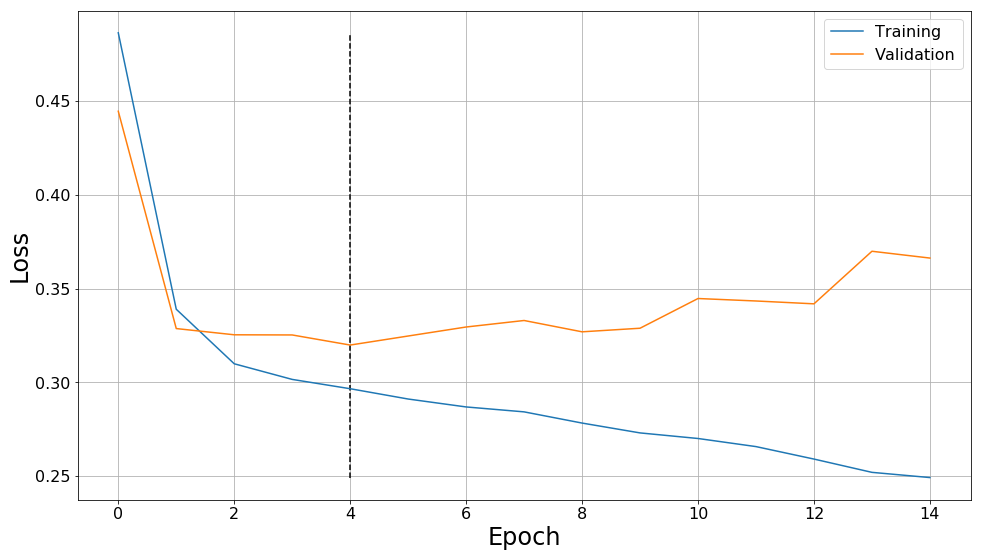

In [61]:
hist = model.fit(x=x, y=y, x_val=x_val, y_val=y_val, batchsize=128, n_epochs=15, lr=2e-3, loss_fn=BCELoss(), wd=1e-5)

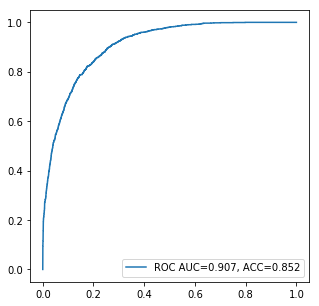

In [62]:
_ = score_model(model, x_val, y_val)

So, by tuning the amount of regularaisation we reached even better performance using the larger model. Of course the smaller model might still be over-fitting and could also benefit from regularisation...